In [1]:
import numpy as np
import itertools

#Global variables
beta=1
N=4*beta #number of beads # n=4beta 
betaN=beta/N
hbar=1
m=1

def force(x,f_type):#f_type more clean, (what to do for exeption but all that later)
    f_all =-(m/((betaN**2) * (hbar**2))) * (2*x-np.roll(x,1)-np.roll(x,-1))
    if(f_type=='harmonic'):
        return -x +f_all
    if(f_type=='perturbed_harmonic'):
        return -(x +0.3*x**2 +0.04*x**3) +f_all
    if(f_type=='quartic'):
        return -(x**3)+f_all

def generate_p():
    return np.random.normal(0,np.sqrt(m/betaN),N)


def propagate_x_and_p(numsteps, dt ,x_init, p_init,f_type):
    p_tmp=p_init
    x_tmp=x_init
    for _ in itertools.repeat(None, numsteps):
        p_tmp= p_tmp+force(x_tmp,f_type)*dt/2
        x_tmp= x_tmp + dt*p_tmp/m
        # x_cart = G * X_nm
        # f_cart(x_cart)
        # F_nm = T * f_cart
        p_tmp= p_tmp+ force(x_tmp,f_type)*dt/2
    return x_tmp,p_tmp

def propagate_x_and_p_nm(numsteps, dt ,x_init, p_init,f_type,G,G_inv):
    p_tmp=p_init
    x_tmp=x_init
    for _ in itertools.repeat(None, numsteps):
        x_cart = x_tmp @ G_inv#
        F_nm=force(x_cart,f_type)@G#
        p_tmp= p_tmp+F_nm*dt/2
        x_tmp= x_tmp + dt*p_tmp/m
        x_cart = x_tmp @ G_inv#
        F_nm=force(x_cart,f_type)@G#
        p_tmp= p_tmp+ F_nm*dt/2
    return x_tmp,p_tmp

#energy conservation check
def calculate_energy(x,p,f_type):
    E_kin=np.sum(p**2)/(2*m)
    V=0
    if(f_type=='harmonic'):
        V=0.5*np.sum(x**2)
    if(f_type=='perturbed_harmonic'):
        V=0.5*np.sum(x**2)+0.1*np.sum(x**3)+0.01*np.sum(x**4)
    if(f_type=='quartic'):
        V=0.25*np.sum(x**4)
    V_springs=(m/(2*(betaN**2) * (hbar**2)))*np.sum((x-np.roll(x,1))**2)
    E_tot=E_kin+V+V_springs
    return E_tot 

def cart_to_nm_and_inverse(N):
    G=np.zeros((N,N))
    for j in range(N):
        for k in range(N):
            if(k==0):
                G[j,k]=1
                #print('A', j,k)
            if(1<=k<=(N/2-1)):
                G[j,k]=np.sqrt(2)*np.cos((2*np.pi*j*k)/N)
                #print('B', j,k)
            if(k==N/2):
                G[j,k]=(-1)**j
                #print('C', j,k)
            if((N/2+1)<=k<=(N-1)):
                #print('D', j,k)
                G[j,k]=np.sqrt(2)*np.sin((2*np.pi*j*k)/N)
    G_cart_to_nm= (1/np.sqrt(N))*G
    return G_cart_to_nm, G_cart_to_nm.transpose()

In [96]:
num_steps=100
dt=0.05 #difference between normal modes if factor of 4 included
#f_type='harmonic'
f_type='perturbed_harmonic'
#f_type='quartic'

seeds=3
full_tcf=np.zeros((seeds,num_steps))
sampling_rate=5
num_traj=500
#loop over random seeds
for k in range(seeds):
    print(k+1,'/',seeds)
    np.random.seed(k)
    tcf = np.zeros(num_steps)
    G, G_inv= cart_to_nm_and_inverse(N)
    for _ in itertools.repeat(None, num_traj):
        p0=generate_p()
        x_initial=np.zeros(N)
        x0,p0 = propagate_x_and_p(numsteps=100, dt=dt,x_init=x_initial,p_init=p0,f_type=f_type) #first run s.t. x0 is also unbiased
        #initialized all values above
        x0_cen=np.sum(x0)/N #for cartesian
        x0_nm=x0[0]#for nm
        pt=p0
        xt=x0
        for j in range(num_steps):
                ### cartesian
                xt_cen=np.sum(xt)/N
                tcf[j]+=x0_cen * xt_cen #cartesian
                xt,pt = propagate_x_and_p(numsteps=sampling_rate,dt=dt,x_init=xt,p_init=pt,f_type=f_type)
                ### normal mode
                #tcf[j]+= x0_nm*xt[0]
                #xt,pt = propagate_x_and_p_nm(numsteps=sampling_rate,dt=dt,x_init=xt,p_init=pt,f_type=f_type,G=G,G_inv=G_inv)
                

    tcf /= num_traj
    full_tcf[k]=tcf
 

1 / 3
2 / 3
3 / 3


In [11]:
num_steps=100
dt=0.05 #difference between normal modes if factor of 4 included
#f_type='harmonic'
f_type='perturbed_harmonic'
#f_type='quartic'

seeds=3
full_tcf=np.zeros((seeds,num_steps))
sampling_rate=5
num_traj=400

#loop over random seeds
for k in range(seeds):
    print(k+1,'/',seeds)
    np.random.seed(k)
    tcf = np.zeros(num_steps)
    G, G_inv= cart_to_nm_and_inverse(N)

    for _ in itertools.repeat(None, num_traj):
        p0=generate_p()
        x0=np.zeros(N)
        x0,p0 = propagate_x_and_p(numsteps=100, dt=dt,x_init=x0,p_init=p0,f_type=f_type) #first run s.t. x0 is also unbiased
        #initialized all values above
        x0_cen=np.sum(x0)/N #for cartesian
        x0_nm=x0[0]#for nm
        pt=p0
        xt=x0
        xt_cent_vec=np.zeros(2*num_steps)

        for j in range(2*num_steps):
                ### cartesian
                xt_cen=np.sum(xt)/N
                xt_cent_vec[j]=xt_cen
                #tcf[j]+=x0_cen * xt_cen #cartesian
                xt,pt = propagate_x_and_p(numsteps=sampling_rate,dt=dt,x_init=xt,p_init=pt,f_type=f_type)
        
        for j in range(num_steps):
            tcf[j] += np.dot(xt_cent_vec[0:num_steps],xt_cent_vec[j:num_steps + j])
    tcf /= (num_traj*num_steps)
    full_tcf[k]=tcf
 

1 / 3
2 / 3
3 / 3


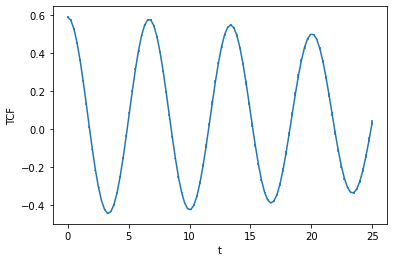

In [12]:
import matplotlib.pyplot as plt
mean_tcf = np.mean(full_tcf,axis=0)
std_tcf = np.std(full_tcf,axis=0)  
t=np.linspace(start=0,stop=num_steps*dt*sampling_rate,num=num_steps)
#plt.plot(t,mean_tcf)
plt.errorbar(t,mean_tcf, yerr=std_tcf )
plt.ylabel('TCF')
plt.xlabel('t')
#plt.text( x= 5,y=0.08, s=r'$\beta$')
plt.show()


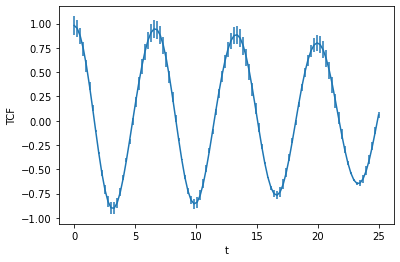

In [98]:
#second one in order to compare
import matplotlib.pyplot as plt
mean_tcf = np.mean(full_tcf,axis=0)
std_tcf = np.std(full_tcf,axis=0)  
t=np.linspace(start=0,stop=num_steps*dt*sampling_rate,num=num_steps)
#plt.plot(t,mean_tcf)
plt.errorbar(t,mean_tcf, yerr=std_tcf )
plt.ylabel('TCF')
plt.xlabel('t')
#plt.text( x= 5,y=0.08, s=r'$\beta$')
plt.show()

In [10]:
if(False): #pseudocode
    seeds=10
    full_tcf = np.zeros((N, seeds))
    for s in range(seeds)
        rand.seed(seed)
        tcf = np.zeros(N)
        for i in ntraj:
            for k in times_sample
                sample_p()
                for j in nsteps_thermalize:
                    propagate_1_step()
            x0 = centroid()
            for j in run_steps:
                tcf[j] += x0 * centroid()
                propgate_1_step()
                

        tcf /= ntraj
        full_tcf[s] = tcf
    np.mean(full_tcf)
    np.stddev(full_tcf)    

SyntaxError: invalid syntax (4290328515.py, line 4)